In [1]:
import pandas as pd
import numpy as np
import operator
import re
import nltk
from nltk.tokenize import word_tokenize
import pickle
import matplotlib.pyplot as pltpartial_y_test_cv
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import seaborn as sns
import time

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc

from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D,MaxPooling1D

from keras.layers import Input, Dense, Flatten,Embedding, SpatialDropout1D, Dropout, add, concatenate,SimpleRNN, LSTM
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D,BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn.externals import joblib

Using TensorFlow backend.


## Part I Data preparation

### Step 1.Cleaning

In [2]:
tr = pd.read_csv('train_treated.csv')
te = pd.read_csv('test_treated.csv')

In [3]:
with open('glove.pickle', 'rb') as handle:
     saved_glove=pickle.load(handle)

In [4]:
with open('meta_embed.pickle', 'rb') as handle:
     saved_meta=pickle.load(handle)

In [5]:
x_tr=tr['treated_comment']
x_te=te['treated_comment']
y_tr = np.where(tr['target'] >= 0.5, 1, 0).astype(int) 

y_identity=tr[[
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']]

In [6]:
y_identity=y_identity.fillna(0)
y_identity=np.where(y_identity >= 0.5, 1, 0).astype(int)

In [7]:
x_tr_c=x_tr.map(lambda x: re.sub(r'\W+', ' ',x))
x_te_c=x_te.map(lambda x: re.sub(r'\W+', ' ',x))

### Step 2 Data Splitting

In [ ]:
#consider the dataset is very large in this case, we will not consider cross validation at the beginning.

In [8]:
X_tr = pd.DataFrame(x_tr_c)
Y_tr = pd.Series(y_tr)
partial_x_train, x_val, partial_y_train, y_val = train_test_split(
    X_tr,
    Y_tr,
    test_size=0.2,
    random_state=1)

In [9]:
train_indices=partial_x_train.index
test_indices= x_val.index

In [10]:
y_identity_te=y_identity[test_indices]

## Part II Bag of word model

In [ ]:
#before bag of word, stemmetize the text

In [11]:
nltk.download('stopwords')
nltk.download('punkt')
stemmer = PorterStemmer().stem 
tokenize = nltk.word_tokenize 
def stem(tokens,stemmer= PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens] 
def lemmatize(text): 
    return stem(tokenize(text))
def join(text): 
    return ' '.join(lemmatize(text))

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
x_val_token=x_val.copy()
x_val_token['treated_comment']=x_val_token['treated_comment'].map(lambda x: join (x))

#### Be careful! Below code runs >15 min

In [13]:
partial_x_train_token=partial_x_train.copy()
partial_x_train_token['treated_comment']=partial_x_train_token['treated_comment'].map(lambda x: join (x))

In [14]:
with open('partial_x_train_token.pickle', 'wb') as handle:
    pickle.dump(partial_x_train_token, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
with open('x_val_token.pickle', 'wb') as handle:
    pickle.dump(x_val_token, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
tf_vector = TfidfVectorizer()
X_tr_tf= tf_vector.fit_transform(partial_x_train_token['treated_comment'].values)
x_val_tf=tf_vector.transform(x_val_token['treated_comment'].values)

#### Be careful! Below code runs >10 min

In [18]:
gridParams = {
   'objective' : ['binary'],   
    'n_estimators': [20,40],
    'num_leaves': [12,64],
    'boosting_type' : ['gbdt'],
    }
model_b = lgb.LGBMClassifier()
lgb_grid = GridSearchCV(estimator = model_b, param_grid= gridParams,cv = 2, n_jobs = -1)
lgb_grid.fit(X_tr_tf,partial_y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'objective': ['binary'], 'n_estimators': [20, 40], 'num_leaves': [12, 64], 'boosting_type': ['gbdt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
model_b=lgb_grid.best_estimator_
model_b

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=40, n_jobs=-1, num_leaves=64, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [23]:
joblib.dump(model_b, 'model_b.pkl', compress = 1)

['model_b.pkl']

In [24]:
model_b = joblib.load('model_b.pkl')

In [25]:
model_b.fit(X_tr_tf,partial_y_train)
y_pred_prob=model_b.predict_proba(x_val_tf)

In [28]:
def roc_pr(y_pred_prob,y_val): 
    fpr_svc,tpr_svc,threshs=metrics.roc_curve(y_val,y_pred_prob,pos_label=1)
    prec_svc,rec_svc,threshs=metrics.precision_recall_curve(y_val,y_pred_prob)
    
    plt.plot(fpr_svc,tpr_svc,label='lightGBM')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.title("ROC curve")
    
    plt.figure(figsize=(6,6))
    plt.plot(rec_svc,prec_svc,label='lightGBM')
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.legend()
    plt.title("PR curve")

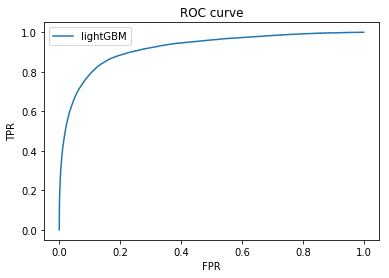

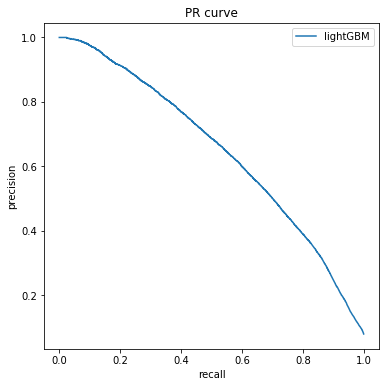

In [29]:
roc_pr(y_pred_prob[:, 1],y_val)

In [267]:
roc_auc_score(y_val,y_pred_prob[:, 1])

0.9187727719717355

## Part III CNN

### Step1 Build embedding matrix

In [ ]:
#It is suggested that stemmitization and tokenization may remove important features that are useful in deep learning models. Thus, for deep learning models, I will not use stemmized tokens.

In [11]:
def embed(train,test,embed_glove): 
    t = Tokenizer()
    t.fit_on_texts(train)
    vocab_size = len(t.word_index) + 1
    
    encoded_docs_tr = t.texts_to_sequences(train)
    max_length = max([len(s.split()) for s in train])
    padded_tr=pad_sequences(encoded_docs_tr, maxlen=max_length, padding='post')
    
    encoded_docs_te = t.texts_to_sequences(test)
    padded_te=pad_sequences(encoded_docs_te, maxlen=max_length, padding='post')
    
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in t.word_index.items():
        embedding_vector = embed_glove.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return padded_tr,padded_te, embedding_matrix,max_length

#### Be careful! Below cell runs for >10 mins

In [12]:
pad_tr,pad_te, embedding_matrix,max_length=embed(x_tr_c,x_te_c,saved_glove)

In [13]:
pad_partial_x_tr=pad_tr[train_indices]
pad_x_val=pad_tr[test_indices]

### Step2 CNN model

In [265]:
model1 = Sequential()
model1.add(Embedding(*embedding_matrix.shape, weights=[embedding_matrix], input_length=max_length, trainable=False))
model1.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model1.add(MaxPooling1D(pool_size=5))
model1.add(Conv1D(128, 5, activation='relu'))
model1.add(MaxPooling1D(5))
model1.add(Conv1D(128, 5, activation='relu'))
model1.add(MaxPooling1D(5))

model1.add(Flatten())
model1.add(Dense(units=128, activation='relu'))
model1.add(Dense(units=1, activation='softmax'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 327, 300)          87027900  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 323, 128)          192128    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 64, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 60, 128)           82048     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 12, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 8, 128)            82048     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1, 128)            0         
__________

In [266]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])   

In [272]:
history1 = model1.fit(pad_partial_x_tr,
                    partial_y_train,
                    epochs=1,
                    batch_size=64,
                    validation_data=(pad_x_val, y_val),
                    verbose=1)
print(model1.summary())

Train on 1443899 samples, validate on 360975 samples
Epoch 1/1
1443899/1443899 [==============================] - 340s 235us/step - loss: 14.6655 - acc: 0.0801 - val_loss: 14.6753 - val_acc: 0.0795
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 327, 300)          87027900  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 323, 128)          192128    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 64, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 60, 128)           82048     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 12, 128)           0         
_________________________________________________________________
conv1d_6 (

Since the accuracy score is too bad. We will just abandon CNN.

## Part IV RNN

Implement many-to-one LSTM with dense layer. 

In [14]:
model_r1 = Sequential()
model_r1.add(Embedding(*embedding_matrix.shape, weights=[embedding_matrix], input_length=max_length, trainable=False))
model_r1.add(CuDNNLSTM(64)) 
model_r1.add(Dropout(0.5))
model_r1.add(Dense(1, activation='sigmoid'))

model_r1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### Be careful! Below code runs >30 min

In [41]:
history_r1 = model_r1.fit(pad_partial_x_tr,
                    partial_y_train,
                    epochs=5, 
                    batch_size=512,
                    validation_data=(pad_x_val, y_val),
                    verbose=1)                   

Train on 1443899 samples, validate on 360975 samples
Epoch 1/5
1443899/1443899 [==============================] - 235s 162us/step - loss: 0.2826 - acc: 0.9199 - val_loss: 0.2776 - val_acc: 0.9205
Epoch 2/5
1443899/1443899 [==============================] - 234s 162us/step - loss: 0.2814 - acc: 0.9199 - val_loss: 0.2775 - val_acc: 0.9205
Epoch 3/5
1443899/1443899 [==============================] - 235s 163us/step - loss: 0.2804 - acc: 0.9199 - val_loss: 0.2776 - val_acc: 0.9205
Epoch 4/5
1443899/1443899 [==============================] - 235s 163us/step - loss: 0.2798 - acc: 0.9199 - val_loss: 0.2776 - val_acc: 0.9205
Epoch 5/5
1443899/1443899 [==============================] - 234s 162us/step - loss: 0.2795 - acc: 0.9199 - val_loss: 0.2775 - val_acc: 0.9205


In [42]:
def plothis(history): 
    history_dict = history.history
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()  

    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

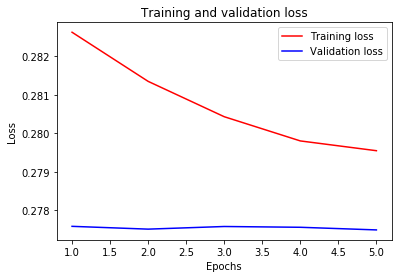

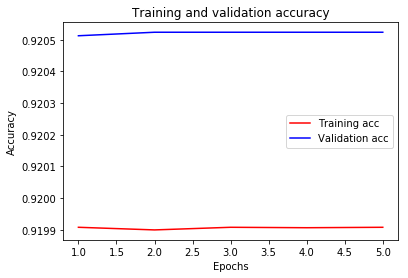

In [43]:
plothis(history_r1)

Here, the validation loss is close but slightly lower than training loss. It could be due to overfitting, larger amount of data in training sample where errors are calculated; 
It has also been suggested that dropout layer tends be activated during the training, but deactivated during validation. See ref: https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error

## Part V Define Metrics

Before tuning, we need to look at the metrics with which tuning results will be compared since it is not just important to classify the the text, but also to minimize the bias which is calculated through following defined metric function.

<img src="metric.png">

In [14]:
class metric: 
    def __init__(self,y_true, y_pred,y_identity):
        self.y_true=y_true
        self.y_pred=y_pred
        self.y_identity=y_identity
        self.N=y_identity.shape[1]
        self.p=-5
    @staticmethod
    def auc(y_true, y_prob):
        return roc_auc_score(y_true, y_prob)

    def power_mean(self,array):
        total = sum(np.power(array,self.p))/len(array)  
        return np.power(total, 1/ self.p)
    def overall_auc(self): 
        return self.auc(self.y_true,self.y_pred)       
    
    def mp_sub(self):
        sub=[]
        for i in range(self.N):
            sub_y_true=self.y_true.values[self.y_identity[:,i]==1]
            sub_y_pred=self.y_pred[self.y_identity[:,i]==1]   
            sub_auc_i=self.auc(sub_y_true,sub_y_pred)
            sub.append(sub_auc_i)
        self.mp_sub=self.power_mean(sub)
        return self.mp_sub
    
    def mp_bpsn(self): 
        sub=[]
        for i in range(self.N):
            sub_y_true=self.y_true.values[self.y_identity[:,i]+self.y_true==1]
            sub_y_pred=self.y_pred[self.y_identity[:,i]+self.y_true==1]   
            sub_auc_i=self.auc(sub_y_true,sub_y_pred)
            
            sub.append(sub_auc_i) 
    
        return self.power_mean(sub)
    
    def mp_bnsp(self): 
        sub=[]
        for i in range(self.N):
            sub_y_true=self.y_true.values[(self.y_identity[:,i]+self.y_true==2)|(self.y_identity[:,i]+self.y_true==0)]
            sub_y_pred=self.y_pred[(self.y_identity[:,i]+self.y_true==2)|(self.y_identity[:,i]+self.y_true==0)]
            sub_auc_i=self.auc(sub_y_true,sub_y_pred)
            sub.append(sub_auc_i)
        return self.power_mean(sub)  


In [35]:
def get_metric_outcome(y_val, y_prob,y_identity):
    evaluator = metric(y_val, y_prob,y_identity)
        
    overall_auc=evaluator.overall_auc()
        
    sub_value=evaluator.mp_sub()
    bpsn=evaluator.mp_bpsn()
    bnsp=evaluator.mp_bnsp()
       
    avg_auc=0.25*overall_auc+0.25*sub_value+0.25*bpsn+0.25*bnsp
    result=[overall_auc,sub_value,bpsn,bnsp,avg_auc]    
    return result

In [16]:
def plot_performance(model,result):
    x=['auc','mp_sub','mp_bpsn','mp_bnsp','avg_auc']
    ax = sns.stripplot(x,result)
    plt.ylabel('Accuracy')
    plt.legend()         
    plt.title('{} model performance'.format(model))

## Part VI Light-GBM vs RNN

#### Below is for lgb:

In [358]:
def fit_lgb(model_b,x_train,y_train,x_val):
    model_b.fit(x_train,y_train)
    y_pred=model_b.predict_proba(x_val,verbose=0)
    return y_pred[:, 1]

In [359]:
y_pred=fit_lgb(model_b,X_tr_tf,partial_y_train,x_val_tf)

In [360]:
result=get_metric_outcome(y_val,y_pred,y_identity_te)

No handles with labels found to put in legend.


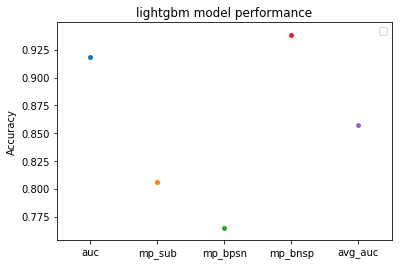

In [363]:
plot_performance('lightgbm',result)

#### Be careful! Below cell runs >5 mins!

Check performance for RNN

In [49]:
model_r1.fit(pad_partial_x_tr,
                    partial_y_train,
                    epochs=1, 
                    batch_size=512,
                    verbose=1)

Epoch 1/1
1443899/1443899 [==============================] - 216s 150us/step - loss: 0.2844 - acc: 0.9199


In [18]:
def model_performance_rnn(y_pred,y_val,y_identity_te,name):
    result=get_metric_outcome(y_val,y_pred.ravel(),y_identity_te)
    plot_performance (name,result)

In [59]:
y_pred_r1=model_r1.predict(pad_x_val,verbose=1)

360975/360975 [==============================] - 90s 249us/step


No handles with labels found to put in legend.


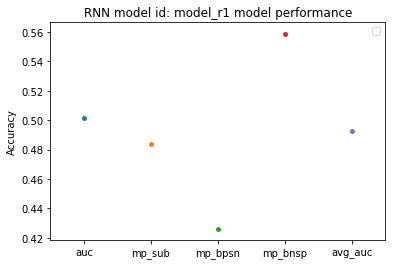

In [60]:
model_performance_rnn(y_pred_r1,y_val,y_identity_te,'RNN model id: model_r1')

## Part VII RNN Model tuning 

### Model 1. Slight modification on vanilla RNN:
#### a. Change to mixed embedding and add other tabular features
#### b. Use bidirectional RNN

In [20]:
pad_tr_meta,pad_te_meta, embedding_matrix_meta,max_length_meta=embed(x_tr_c,x_te_c,saved_meta)

In [21]:
metapad_partial_x_tr=pad_tr_meta[train_indices]
metapad_x_val=pad_tr_meta[test_indices]

In [22]:
additional_data_tr=tr.iloc[train_indices,:][['polarity','subjectivity','unique_word_count','total_word_count']]
additional_data_val=tr.iloc[test_indices,:][['polarity','subjectivity','unique_word_count','total_word_count']]
#number of engineered features 
engineered_length=4

In [23]:
#normalize above features 
scaler = StandardScaler()
additional_data_tr=scaler.fit_transform(additional_data_tr)
additional_data_val=scaler.fit_transform(additional_data_val)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [47]:
input1 = Input(shape=(max_length_meta,))
input2 = Input(shape=(engineered_length,))

x=Embedding(*embedding_matrix_meta.shape, weights=[embedding_matrix_meta], trainable=False)(input1)
x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
x=Dense(4, activation='sigmoid')(x)
x = SpatialDropout1D(0.25)(x)
x=Flatten()(x)
x = concatenate([x, input2])
output=Dense(1, activation='sigmoid', name = 'main_output')(x)
model_r2 = Model(inputs=[input1, input2], outputs=output)
model_r2.compile(
        loss='binary_crossentropy',
        optimizer=Adam(clipnorm=0.1),
        metrics=['accuracy'])

In [45]:
model_r2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 327)          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 327, 300)     87027900    input_16[0][0]                   
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 327, 128)     187392      embedding_9[0][0]                
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 327, 4)       516         bidirectional_8[0][0]            
__________________________________________________________________________________________________
spatial_dr

#### Below cell runs >10 mins!

In [48]:
model_r2.fit([metapad_partial_x_tr,additional_data_tr],partial_y_train,epochs=1,batch_size=512,verbose=1)      

Epoch 1/1
1443899/1443899 [==============================] - 465s 322us/step - loss: 0.1561 - acc: 0.9424


In [49]:
y_pred_r2=model_r2.predict([metapad_x_val,additional_data_val],verbose=1)

360975/360975 [==============================] - 187s 519us/step


No handles with labels found to put in legend.


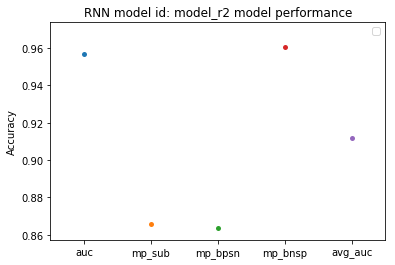

In [50]:
model_performance_rnn(y_pred_r2,y_val,y_identity_te,'RNN model id: model_r2')

### Model 2. Complex architecture 1
This is inspired by following discusssion 
https://mlwhiz.com/blog/2019/02/19/siver_medal_kaggle_learnings/

In [24]:
input1= Input(shape=(max_length_meta,))
input2= Input(shape=(engineered_length,))

x = Embedding(*embedding_matrix_meta.shape, weights=[embedding_matrix_meta], trainable=False)(input1)
x = SpatialDropout1D(0.25)(x)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x) #128
x=Conv1D(filters=64, kernel_size=5, activation='relu')(x) #64

#added engineered feature as dense layer and concat with 1d global max pooling 
hidden = concatenate([
        GlobalMaxPooling1D()(x),
        Dense(64, activation='sigmoid')(input2)
    ])
x=Dense(128, activation='sigmoid')(hidden) #128
#added dropout layer 
x = Dropout(0.25)(x)

#added batch normalization layer
x=BatchNormalization()(x)
output=Dense(1, activation='sigmoid')(x)

model_r3 = Model(inputs=[input1, input2], outputs=output)
model_r3.compile(
        loss='binary_crossentropy',
        optimizer=Adam(clipnorm=0.1),
        metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [24]:
model_r3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 327)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 327, 300)     87027900    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 327, 300)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 327, 256)     440320      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
conv1d_1 (

#### Below cell runs >10 mins!

In [25]:
model_r3.fit([metapad_partial_x_tr,additional_data_tr],partial_y_train,epochs=1,batch_size=512,verbose=1)   

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/1
1443899/1443899 [==============================] - 924s 640us/step - loss: 0.1509 - acc: 0.9405


In [26]:
y_pred_r3=model_r3.predict([metapad_x_val,additional_data_val],verbose=1)

360975/360975 [==============================] - 212s 587us/step


No handles with labels found to put in legend.


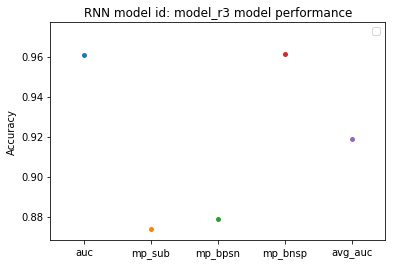

In [27]:
model_performance_rnn(y_pred_r3,y_val,y_identity_te,'RNN model id: model_r3')

### Model 3. Complex architecture 2
This is inspired by the following kernel:https://www.kaggle.com/thousandvoices/simple-lstm

In [32]:
input1= Input(shape=(max_length_meta,))

x = Embedding(*embedding_matrix_meta.shape, weights=[embedding_matrix_meta], trainable=False)(input1)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)

hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x)
    ])
hidden = add([hidden, Dense(512, activation='tanh')(hidden)])
hidden = add([hidden, Dense(512, activation='relu')(hidden)])
result = Dense(1, activation='sigmoid', name = 'main_output')(hidden)

model_r4 = Model(inputs=input1, outputs=result)

model_r4.compile(
        loss='binary_crossentropy',
        optimizer=Adam(clipnorm=0.1),
        metrics=['accuracy'])

In [33]:
model_r4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 327)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 327, 300)     87027900    input_6[0][0]                    
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 327, 256)     440320      embedding_5[0][0]                
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 327, 256)     395264      bidirectional_6[0][0]            
__________________________________________________________________________________________________
global_max

In [35]:
start = time.time()
print("start")
model_r4.fit(metapad_partial_x_tr,partial_y_train,epochs=1,batch_size=512,verbose=1)  
end = time.time()
print(end - start)

start
Epoch 1/1
1443899/1443899 [==============================] - 1562s 1ms/step - loss: 0.1314 - acc: 0.9485
1563.7611012458801


In [37]:
print((end - start)/60)

26.06268502076467


In [38]:
y_pred_r4=model_r4.predict(metapad_x_val,verbose=1)

360975/360975 [==============================] - 426s 1ms/step


No handles with labels found to put in legend.


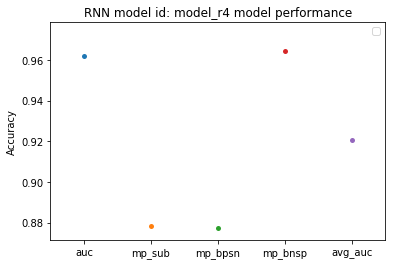

In [39]:
model_performance_rnn(y_pred_r4,y_val,y_identity_te,'RNN model id: model_r4')

#### This architecture iterally took 26 mins to train, but not significantly improving the scores.

#### Based on above, I decided to choose model_r3

<img src="finalmodel.png">

#### Below is to predict test set, which will be used for submission to Kaggle competition.

In [40]:
additional_data_te=te[['polarity','subjectivity','unique_word_count','total_word_count']]

In [41]:
y_pred_r3_for_test=model_r3.predict([pad_te_meta,additional_data_te],verbose=1)    

97320/97320 [==============================] - 58s 596us/step


In [53]:
predictions=(y_pred_r3_for_test>0.5)*1

In [52]:
submission = pd.DataFrame.from_dict({
    'id': te['id'],
    'prediction': predictions.ravel
})
submission.to_csv('submission.csv', index=False)